In [3]:
import numpy as np
import pandas as pd
import torch
import math
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

In [23]:
LOOKUP_TABLE = 'theseusqfls/data/lookup_table.csv'
h = 4.1357e-15
c = 2.9979e8
k = 8.6173e-5
q = 1.602e-19
T = 298.15
alpha = 10

def gen_lookup_table():
    nx = round(1.5 / 0.05) + 1
    ny = round((100 + 60) / 0.1) + 1
    d = pd.read_csv(LOOKUP_TABLE, names=['G'], usecols=[2])
    theta = np.linspace(0.5, 2, nx)
    theta_fine = np.linspace(0.5, 2, nx * 50)
    energy = np.linspace(-60, 100, ny)
    energy_fine = np.linspace(-60, 100, ny * 50)
    d = np.reshape(d['G'].to_numpy(), (nx, ny))
    G = RectBivariateSpline(theta, energy, d, kx=3, ky=3, s=0)
    d_theta = torch.tensor(G.partial_derivative(1, 0)(theta_fine, energy_fine), dtype=torch.float32)
    d_energy = torch.tensor(G.partial_derivative(0, 1)(theta_fine, energy_fine), dtype=torch.float32)
    G_tensor = torch.tensor(G(theta_fine, energy_fine), dtype=torch.float32)
    return torch.tensor(theta_fine, dtype=torch.float32), torch.tensor(energy_fine, dtype=torch.float32), d_theta, d_energy, G_tensor

def interp_index(arr, val):
    arr_min = val.unsqueeze(-1) - arr.unsqueeze(0)
    values, indices = torch.min(torch.abs(arr_min), -1)
    return indices

def generate_gen_planck(E, qfls, gamma, theta, bandgap, n_series):
    theta_fine, energy_fine, d_theta, d_energy, G = gen_lookup_table()
    i_theta = interp_index(theta_fine, theta)
    i_energy = interp_index(energy_fine, (E - bandgap) / gamma)
    a = 40 * torch.sqrt(gamma) * G[i_theta, i_energy]
    part1 = 2 * math.pi * E ** 2 / (h ** 3 * c ** 2) * math.e ** (-E / (k * T))
    part2 = math.e ** (qfls / (k * T))
    part3 = torch.stack([(-1) ** (n - 1) * a ** n / math.factorial(n) for n in range(1, n_series)], dim=0).sum(dim=0)
    # part3 = 1 - math.e ** (-40 * torch.sqrt(gamma) * G[i_theta, i_energy])
    return part1 * part2 * part3

def generate_part3_taylor(energy, qfls, gamma, theta, bandgap, n_series):
    theta_fine, energy_fine, d_theta, d_energy, G = gen_lookup_table()
    i_theta = interp_index(theta_fine, theta)
    i_energy = interp_index(energy_fine, (energy - bandgap) / gamma)
    a = 40 * torch.sqrt(gamma) * G[i_theta, i_energy]
    part3 = torch.stack([(-1) ** (n - 1) * a ** n / math.factorial(n) for n in range(1, n_series)], dim=0).sum(dim=0)
    return part3

def generate_part3(energy, qfls, gamma, theta, bandgap):
    theta_fine, energy_fine, d_theta, d_energy, G = gen_lookup_table()
    i_theta = interp_index(theta_fine, theta)
    i_energy = interp_index(energy_fine, (energy - bandgap) / gamma)
    part3 = 1 - math.e ** (-40 * torch.sqrt(gamma) * G[i_theta, i_energy])
    return part3

In [24]:
energy = torch.linspace(1.5, 1.7, 100).unsqueeze(dim=0)
qfls = 1.15*torch.ones((1, 1))
gamma = 0.01*torch.ones((1, 1))
theta = 1.0*torch.ones((1, 1))
bandgap = 1.6*torch.ones((1, 1))

pl = generate_gen_planck(energy, qfls, gamma, theta, bandgap, n_series=20)
part3_taylor = generate_part3_taylor(energy, qfls, gamma, theta, bandgap, n_series=20)
part3 = generate_part3(energy, qfls, gamma, theta, bandgap)

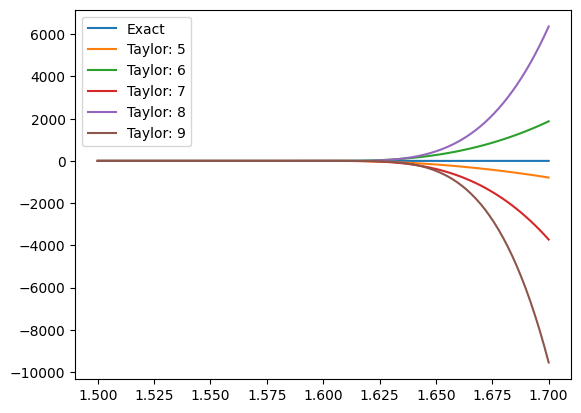

In [28]:
fig, ax = plt.subplots()
ax.plot(torch.squeeze(energy), torch.squeeze(part3), label='Exact')
for n in range(5, 10):
    ax.plot(torch.squeeze(energy), torch.squeeze(generate_part3_taylor(energy, qfls, gamma, theta, bandgap, n_series=n)), label=f'Taylor: {n}')
ax.legend()

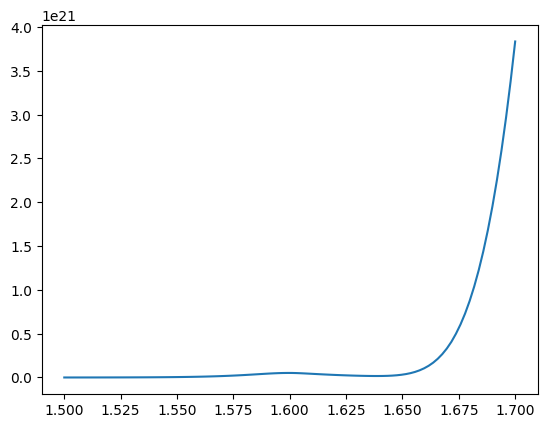

In [22]:
fig, ax = plt.subplots()
ax.plot(torch.squeeze(energy), torch.squeeze(pl))